In [1]:
!pip install kagglehub nltk -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
from kagglehub import KaggleDatasetAdapter

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "nikhileswarkomati/suicide-watch",
    "Suicide_Detection.csv",
)

### Data Inspection

In [4]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
df.shape

(232074, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [7]:
df = df.drop(columns = 'Unnamed: 0', axis=1)

In [8]:
df = df.rename(columns={
    'class': 'is_suicidal'
})

In [9]:
df['is_suicidal'].unique()

array(['suicide', 'non-suicide'], dtype=object)

In [10]:
df['is_suicidal'] = df['is_suicidal'].apply(lambda x: 1 if x.strip().lower() == 'suicide' else 0)

In [11]:
df.isnull().sum()

text           0
is_suicidal    0
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.head()

,text,is_suicidal
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [14]:
df['is_suicidal'].value_counts()

is_suicidal
1    116037
0    116037
Name: count, dtype: int64

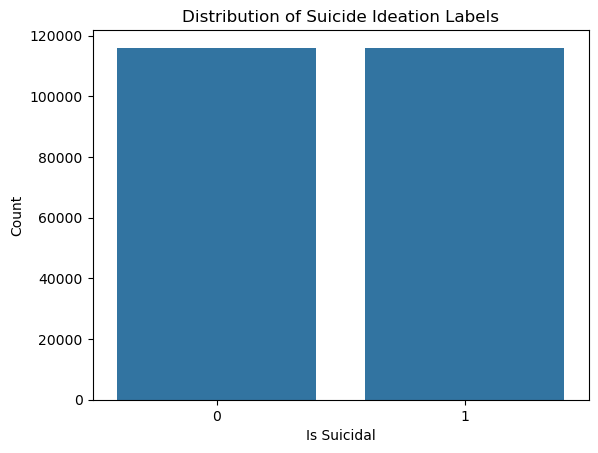

In [15]:
sns.countplot(x='is_suicidal', data=df)
plt.title('Distribution of Suicide Ideation Labels')
plt.xlabel('Is Suicidal')
plt.ylabel('Count')
plt.show()

### Data Preprocessing

In [16]:
df['text_cleaned'] = df['text'].str.lower() # lowercase 
df['text_cleaned'] = df['text_cleaned'].str.replace(r'[^\w\s]+', '',regex = True) # remove remove non-word and non-whitespace characters
df['text_cleaned'] = df['text_cleaned'].str.replace(r'\d', '',regex = True) # remove digits

In [17]:
df['text_tokens'] = df['text_cleaned'].apply(word_tokenize) # tokenization

In [18]:
stop_words = set(stopwords.words('english'))
df['text_tokens_nostop'] = df['text_tokens'].apply(lambda x: [word for word in x if word not in stop_words]) #  remove stopwords

In [19]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    
    return lemmas

In [20]:
df['lemmatized_text'] = df['text_tokens_nostop'].apply(lemmatize_tokens) # lemmatization

In [21]:
# Join back into string for ML models
df['text_ready'] = df['lemmatized_text'].apply(lambda x: ' '.join(x)) 

In [22]:
df = df[['text', 'text_ready', 'is_suicidal']]

In [28]:
df.isnull().sum()

text           0
text_ready     0
is_suicidal    0
dtype: int64

In [23]:
df.to_csv('../data/cleaned_suicide_ideation.csv', index=False)